In [4]:
### distribution line plot of C-read's fragments
### to show frequent contact pair and group across region
### region including bin,compartment,TAD,chromosome...
## import function
import pandas as pd
import numpy as np
import datatable as dt
import gc
from math import ceil
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # True font

In [5]:
def LoadTables(filename, sepstr, usecols):
    dt_df = dt.fread(filename, sep=sepstr, header=True, columns=usecols, fill=True)
    df  = dt_df.to_pandas()
    del dt_df
    gc.collect()
    return(df)

# Loading
def Loading(filename):
    print("Loading %s"%filename)
    usecols = {"read_name","chrom","start","end"}
    VDF_DF = LoadTables(filename, ",",  usecols)
    VDF_DF.columns = ["read_id","chrom","start","end"]
    return(VDF_DF)

# Binsize
def Binsize(binsize, p_array):
    p_array = np.divide(p_array, binsize).astype("int")*binsize
    return(p_array)

In [7]:
## input Merge_Align_Fragment_RvdF.csv
#filename = "/data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/chr14/chr14.Merge_Align_Fragment_RvdF.csv"
filename = "/data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_5Reps.chr2.csv"
fragment = Loading(filename)

Loading /data1/ZJY/Pore-C/Analysis/NA12878/Merge_NA12878/vdFAnnotation/Merge_Align_Fragment_RvdF_5Reps.chr2.csv


In [9]:
## fragment pos and length bin
# BinFragments
bin_size = 25000
#fragment['start'] = Binsize(bin_size, fragment['start'].values)
#fragment['end'] =  Binsize(bin_size, fragment['end'].values)
fragment['middle'] = (fragment['start'] + fragment['end'])/2
fragment['middle'] = Binsize(bin_size, fragment['middle'].values)
print( fragment.head() )
# Fragment count 
FragCount = fragment.groupby("read_id")["start"].count()
FragCount.columns = ["read_id", "Fragnum"]
print( FragCount.head() )

                                read_id chrom      start        end     middle
0  000a99d2-eda8-4fb3-8e81-2090446fbb4d  chr2   30562284   30563544   30550000
1  000a99d2-eda8-4fb3-8e81-2090446fbb4d  chr2   30610366   30611007   30600000
2  01a1f08b-a322-40af-b717-10cae459ad36  chr2  159256972  159257102  159250000
3  022109cd-f991-4cef-bc4a-57480a5df59a  chr2  182996696  182998077  182975000
4  022109cd-f991-4cef-bc4a-57480a5df59a  chr2  205714937  205717724  205700000
read_id
00000078-ff05-4418-966c-01a13d4967e5    2
000000c0-da0e-4ceb-9a7b-8ace163f2401    7
000000e9-0115-46dc-9e33-113e406016c6    4
00000171-61b4-4d40-8376-be3c4f460f96    1
00000424-30c7-47ed-a921-c5b699e9ac1b    2
Name: start, dtype: int64


In [27]:
## loop Domain Laoding
loop_file = "/data1/ZJY/Pore-C/Analysis/HiC_NA12878/Rao2014_Loops/GSE63525_GM12878_hg38_looplist.txt"
## select chromosome
chrselect = 'chr2'
usecols = [True, True, True, True, True, True, False]
regionDF = LoadTables(loop_file,"\t", usecols)
regionDF.columns = ["chrom1", "start1", "end1","chrom2", "start2", "end2"]
## filter chrom filter
regionDF = regionDF.loc[(regionDF['chrom1']==chrselect)&(regionDF['chrom2']==chrselect), :]
### loop size 100,000
loopsize_thred = 100000
regionDF = regionDF.loc[(regionDF.end2 - regionDF.start1) >= loopsize_thred , :]

### sort
regionDF  = regionDF.sort_values(by=["start1","start2"], ignore_index=True)

### binsize
regionDF.loc[:, "pos1bin"] =  Binsize(bin_size ,  (regionDF.start1.values + regionDF.end1.values)/2 )
regionDF.loc[:, "pos2bin"] =  Binsize(bin_size ,  (regionDF.start2.values + regionDF.end2.values)/2 )

regionDF.loc[:, "start1"], regionDF.loc[:, "end1"] = regionDF.pos1bin - bin_size , regionDF.pos1bin + bin_size 
regionDF.loc[:, "start2"], regionDF.loc[:, "end2"] = regionDF.pos2bin - bin_size , regionDF.pos2bin + bin_size 


regionDF['Lindex'] = regionDF.index # loop ID
regionDF['Lindex'] = regionDF.Lindex.apply(lambda x:'L'+str(x+1) ) 
print(regionDF.head())


loop_left_df = regionDF.loc[:, ["chrom1", "start1", "end1","Lindex"]]
loop_left_df.columns = ["chrom", "start", "end","Lindex"]
loop_right_df = regionDF.loc[:, ["chrom2", "start2", "end2","Lindex"]] 
loop_right_df.columns = ["chrom", "start", "end","Lindex"]

print(loop_right_df.head())

  chrom1   start1     end1 chrom2   start2     end2  pos1bin  pos2bin Lindex
0   chr2   200000   250000   chr2   600000   650000   225000   625000     L1
1   chr2   225000   275000   chr2   650000   700000   250000   675000     L2
2   chr2   675000   725000   chr2  1500000  1550000   700000  1525000     L3
3   chr2   825000   875000   chr2  1525000  1575000   850000  1550000     L4
4   chr2  3700000  3750000   chr2  6725000  6775000  3725000  6750000     L5
  chrom    start      end Lindex
0  chr2   600000   650000     L1
1  chr2   650000   700000     L2
2  chr2  1500000  1550000     L3
3  chr2  1525000  1575000     L4
4  chr2  6725000  6775000     L5


In [29]:
## Select Domians
sl_S, sl_E = 176000000, 177400000
P = (regionDF.start1>=sl_S) & (regionDF.end2<=sl_E)
sel_loops = regionDF.loc[P, "Lindex"].values
print(regionDF.loc[P,:])

# Loop color
frag_colors = {}
for loopid in sel_loops:
    frag_colors[loopid] = "r"
    
frag_colors["notin"] = "grey"
frag_colors["other"] = "k"
print(frag_colors )

    chrom1     start1       end1 chrom2     start2       end2    pos1bin  \
420   chr2  176100000  176150000   chr2  176625000  176675000  176125000   
421   chr2  176100000  176150000   chr2  176775000  176825000  176125000   
422   chr2  176100000  176150000   chr2  177125000  177175000  176125000   
423   chr2  176100000  176150000   chr2  176425000  176475000  176125000   
424   chr2  176100000  176150000   chr2  176525000  176575000  176125000   
425   chr2  176625000  176675000   chr2  177100000  177150000  176650000   
426   chr2  176775000  176825000   chr2  177125000  177175000  176800000   
428   chr2  177125000  177175000   chr2  177300000  177350000  177150000   

       pos2bin Lindex  
420  176650000   L421  
421  176800000   L422  
422  177150000   L423  
423  176450000   L424  
424  176550000   L425  
425  177125000   L426  
426  177150000   L427  
428  177325000   L429  
{'L421': 'r', 'L422': 'r', 'L423': 'r', 'L424': 'r', 'L425': 'r', 'L426': 'r', 'L427': 'r', 'L429':

In [33]:
## Find fragments loacated in which loops
## fragments middle pos are distributed into region
fragment.loc[:, 'Lindex'] = len(fragment)*[] # default not in TADs
mid_pos_array = np.array(fragment['middle'])
for i in range(0,len(loop_left_df)):
    tid = loop_left_df['Lindex'][i]
    pos_array = np.array([loop_left_df['start'][i],loop_left_df['end'][i]])
    mid_pos_index = np.searchsorted(pos_array, mid_pos_array, side="left")
    fragment['tindex'].iloc[mid_pos_index==1].append(tid)
fragment.head()

ValueError: Length of values (0) does not match length of index (37248372)

In [8]:
## Filter Reads fragment with select region TADs
P = fragment.tindex.isin( sel_TADs )
selectReads = list( set( fragment.loc[P, "read_id"].to_list() ) )
fil_fragment = fragment.loc[ fragment.read_id.isin(selectReads),  : ]

### Set TAD outside select regions and notin as "other"
otherP = (~ fil_fragment.tindex.isin( sel_TADs ) ) & ( fil_fragment.tindex != "notin" ) 
fil_fragment.loc[otherP, "tindex"] = "other"
print( fil_fragment.head() )

                                  read_id chrom     start       end    middle  \
58   0d7e5af4-786d-422b-b949-e5ddb70b550a  chr2  98718364  98718521  98718000   
59   0d7e5af4-786d-422b-b949-e5ddb70b550a  chr2  98682667  98683042  98682000   
715  a3ab602f-2c6d-41aa-abbb-f754853167de  chr2  15503084  15504358  15503000   
716  a3ab602f-2c6d-41aa-abbb-f754853167de  chr2  15502117  15503079  15502000   
717  a3ab602f-2c6d-41aa-abbb-f754853167de  chr2  99311380  99313553  99312000   

    tindex  
58    T312  
59    T312  
715  other  
716  other  
717   T315  


In [9]:
## read contact type
frag_tad_count = fil_fragment.groupby(['read_id','tindex'])['chrom'].count().reset_index()
frag_tad_count = frag_tad_count.rename(columns={'chrom':'tcount'})
#print(frag_tad_count.head())
read_info = frag_tad_count.groupby('read_id')['tindex'].apply(list).reset_index()
read_info['tcount'] = frag_tad_count.groupby('read_id')['tcount'].apply(list).reset_index()['tcount']
read_info.head()

,read_id,tindex,tcount
0,0001a9be-c02c-44eb-aad3-e22570a5bf57,[T313],[1]
1,0004363e-2de9-4248-b889-9737492fadd7,"[T313, notin, other]","[2, 10, 9]"
2,0007a471-d988-4704-bccb-17353f68c452,"[T312, other]","[5, 3]"
3,00085648-851f-4425-916a-f098f8dc4e3b,"[T313, notin]","[1, 1]"
4,000a2098-3759-41d5-9e15-f5d3a902b2fb,"[T313, T314, T315, other]","[3, 1, 1, 5]"


In [10]:
## Reads Span Region Info
## remove read with single fragment:
read_info = read_info.loc[read_info.tcount.apply(lambda x: x!=[1])] 
## remove read not in any TAD:
read_info = read_info.loc[read_info.tindex.apply(lambda x: x!=['notin'])]

## assign single-TAD read and multi-TAD read
read_info['tindex_only'] = read_info.tindex.apply(lambda x: [t for t in x if t!='notin'])
read_info['type'] = 'single' ## specific TAD only, exclude TAD+notin, T1/T2
read_info['type'].loc[read_info.tindex.apply(lambda x: len(x)>1)] = 'multiple' ## T1+T2 or T1/T2+notin or T1+T2+notin

## Inter TADs
read_info["SpansTADs"] = read_info.tindex_only.apply(lambda x: len([t for t in x if t!='other'])  )
read_info = read_info.set_index("read_id", drop=True, append=False)
read_info 

,tindex,tcount,tindex_only,type,SpansTADs
read_id,,,,,
0004363e-2de9-4248-b889-9737492fadd7,"[T313, notin, other]","[2, 10, 9]","[T313, other]",multiple,1
0007a471-d988-4704-bccb-17353f68c452,"[T312, other]","[5, 3]","[T312, other]",multiple,1
00085648-851f-4425-916a-f098f8dc4e3b,"[T313, notin]","[1, 1]",[T313],multiple,1
000a2098-3759-41d5-9e15-f5d3a902b2fb,"[T313, T314, T315, other]","[3, 1, 1, 5]","[T313, T314, T315, other]",multiple,3
000ec2e5-f665-43ef-bddd-227df959694c,"[T312, T313, notin]","[2, 1, 2]","[T312, T313]",multiple,2
...,...,...,...,...,...
fff8bd57-a085-4cee-9868-a6579f5328ac,"[T312, other]","[1, 3]","[T312, other]",multiple,1
fff934ed-67af-4436-aaee-6a84a5a9bde1,"[T315, other]","[1, 10]","[T315, other]",multiple,1
fffa8957-306f-45cf-a62f-5a2d7a4fa599,"[T312, notin, other]","[1, 6, 1]","[T312, other]",multiple,1


In [11]:
read_info.loc[read_info.SpansTADs>=4, :]

,tindex,tcount,tindex_only,type,SpansTADs
read_id,,,,,
01ad7f7a-6de8-493c-ba42-d4f2a2e11496,"[T312, T313, T314, T315, other]","[1, 3, 1, 1, 2]","[T312, T313, T314, T315, other]",multiple,4
02fd9392-00ed-42f3-8bd7-be9b4bb4100a,"[T312, T313, T314, T315, other]","[5, 1, 1, 3, 10]","[T312, T313, T314, T315, other]",multiple,4
036d4955-44be-4d76-b7bb-c2e19087ab62,"[T312, T313, T314, T315, notin, other]","[1, 1, 1, 1, 5, 1]","[T312, T313, T314, T315, other]",multiple,4
06570524-e861-44d5-bc64-3c5a9b746281,"[T312, T313, T314, T315, notin, other]","[4, 1, 2, 1, 3, 1]","[T312, T313, T314, T315, other]",multiple,4
0846803f-18cb-4a44-9cef-245fa436f68b,"[T312, T313, T314, T315, notin, other]","[1, 1, 1, 1, 2, 3]","[T312, T313, T314, T315, other]",multiple,4
...,...,...,...,...,...
fac1ff89-2d53-4f28-8cdc-7ce1632a7b8b,"[T312, T313, T314, T315, notin, other]","[1, 2, 1, 1, 1, 2]","[T312, T313, T314, T315, other]",multiple,4
fb2e21b2-e729-4acd-a2fe-cc5e82bde479,"[T312, T313, T314, T315, notin, other]","[1, 3, 1, 1, 2, 2]","[T312, T313, T314, T315, other]",multiple,4
fcf90bbc-488a-4e19-8502-77abaccf73a5,"[T312, T313, T314, T315, notin]","[1, 1, 1, 2, 1]","[T312, T313, T314, T315]",multiple,4


In [12]:
## SpanTADs info to Fragment
New_fragment = fil_fragment.loc[fil_fragment.read_id.isin(read_info.index.to_list()),  :] ## filter

New_fragment.loc[:, "type"] = New_fragment["read_id"].apply(lambda x: read_info.loc[x]["type"] )
New_fragment.loc[:, "SpansTADs"] = New_fragment["read_id"].apply(lambda x: read_info.loc[x]["SpansTADs"] )
New_fragment

,read_id,chrom,start,end,middle,tindex,type,SpansTADs
58,0d7e5af4-786d-422b-b949-e5ddb70b550a,chr2,98718364,98718521,98718000,T312,single,1
59,0d7e5af4-786d-422b-b949-e5ddb70b550a,chr2,98682667,98683042,98682000,T312,single,1
715,a3ab602f-2c6d-41aa-abbb-f754853167de,chr2,15503084,15504358,15503000,other,multiple,1
716,a3ab602f-2c6d-41aa-abbb-f754853167de,chr2,15502117,15503079,15502000,other,multiple,1
717,a3ab602f-2c6d-41aa-abbb-f754853167de,chr2,99311380,99313553,99312000,T315,multiple,1
...,...,...,...,...,...,...,...,...
37247515,89e581be-3dae-42ca-9c3e-10108ebc7b34,chr2,98895291,98895691,98895000,T313,multiple,1
37247664,9d39f0a5-1916-4c7a-862d-970cc9aac64d,chr2,98359623,98361355,98360000,notin,multiple,1
37247665,9d39f0a5-1916-4c7a-862d-970cc9aac64d,chr2,98353223,98354569,98353000,notin,multiple,1
37247666,9d39f0a5-1916-4c7a-862d-970cc9aac64d,chr2,99070967,99072311,99071000,T314,multiple,1


In [13]:
def GetFragCount(groupfragment):
    groupfragment.loc[:, "Fragnum"] = groupfragment.loc[:,"read_id"].apply(lambda x:  FragCount.loc[x] )
    return(groupfragment)

### Group Fragment
GroupFragment = {}
for (gtype, sTADs), groupframent in New_fragment.groupby(["type", "SpansTADs"], as_index=False):
    read_ids = list( set( groupframent.read_id.to_list() ) )
    print("Get fragment info for : %s_%s_TADs %d reads"%(gtype, sTADs, len(read_ids) ) )
    #groupframent = SortIndex(groupframent)
    groupframent = GetFragCount(groupframent)    
    GroupFragment[ (gtype, sTADs) ] = groupframent
    groupframent = None
    del groupframent


Get fragment info for : multiple_1_TADs 33892 reads
Get fragment info for : multiple_2_TADs 9033 reads
Get fragment info for : multiple_3_TADs 1513 reads
Get fragment info for : multiple_4_TADs 127 reads
Get fragment info for : single_1_TADs 4500 reads


In [184]:
gtype, sTADs = "multiple", 4
GroupFragment[ (gtype, sTADs) ]

,read_id,chrom,start,end,middle,tindex,type,SpansTADs,Fragnum
1033325,8127d84d-2af8-410e-8f19-69c5cad1eff0,chr2,98818182,98818843,98818000,T312,multiple,4,9
1033326,8127d84d-2af8-410e-8f19-69c5cad1eff0,chr2,98861297,98863469,98862000,T313,multiple,4,9
1033327,8127d84d-2af8-410e-8f19-69c5cad1eff0,chr2,99212584,99213362,99212000,T315,multiple,4,9
1033328,8127d84d-2af8-410e-8f19-69c5cad1eff0,chr2,99083013,99083671,99083000,T314,multiple,4,9
1033329,8127d84d-2af8-410e-8f19-69c5cad1eff0,chr2,99064117,99065658,99064000,T314,multiple,4,9
...,...,...,...,...,...,...,...,...,...
36837002,91801a05-87f6-46a9-b705-c415a5bfee98,chr2,99238044,99239700,99238000,T315,multiple,4,9
36837003,91801a05-87f6-46a9-b705-c415a5bfee98,chr2,99085398,99087289,99086000,T314,multiple,4,9
36837004,91801a05-87f6-46a9-b705-c415a5bfee98,chr2,99073303,99074252,99073000,T314,multiple,4,9
36837005,91801a05-87f6-46a9-b705-c415a5bfee98,chr2,98817126,98817273,98817000,T312,multiple,4,9


In [169]:
## Sorted and 

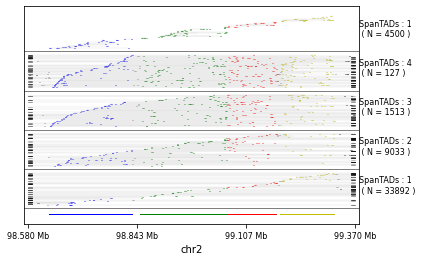

In [15]:
FigFlank = 50000
xmin, xmax = min(sTADs_df['start'])-FigFlank, max(sTADs_df['end'])+FigFlank
import random
random.seed (10)

# reorder reads according to the select TADs
def SortIndex(gf):
    '''
    Sort reads order by the select TADs position
    '''
    ## reads order
    P = (gf.tindex != "notin") & (gf.tindex != "other")
    read_pos_df = gf.loc[P, ["read_id", "start"]].groupby("read_id").min()
    read_pos_df = read_pos_df.reset_index() # read_id
    read_pos_df  = read_pos_df.sort_values("start", ignore_index=True)
    read_pos_df = read_pos_df.reset_index() # order index
    read_pos_df.columns = ["reindex", "read_id", "pos"]
    
    read_pos_df = read_pos_df.set_index("read_id")
    gf.loc[:, "reindex"] = gf.loc[:,"read_id"].apply(lambda x:  read_pos_df.loc[x, "reindex"] )
    gf = gf.sort_values("reindex", ignore_index=True)
    
    return(gf)

def SubSampling(gf, readnums=0):
    '''
    SubSample reads to show.
    0 means all
    '''
    read_ids = list( set( gf.read_id.to_list() ) )
    if len(read_ids) > readnums and readnums != 0:
        sample_ids = random.sample(read_ids, readnums) 
        gf = gf.loc[gf.read_id.isin(sample_ids ), :]
    return(gf)
        
def OutsideRegionFragment(gf, regionS, regionE):
    '''
    read fragment outside specific regions
    '''
    Region_lP = gf.end <= regionS # fragment outside left
    if sum(Region_lP) >= 1:
        gf.loc[Region_lP, "start"] = regionS
        gf.loc[Region_lP, "end"] = regionS + 10000
    
    Region_rP = gf.start >= regionE # fragment outside right
    if sum(Region_rP) >= 1:
        gf.loc[Region_rP, "end"] = regionE
        gf.loc[Region_rP, "start"] = regionE - 10000
    return(gf)
        
def ShortFragmentV(gf, lenthred=5000):
    '''
    let short fragment longth enough to be visible
    '''
    P = gf.end - gf.start <= lenthred
    gf.loc[P, "end"] = gf.loc[P, "end"].values +  0.5*lenthred
    gf.loc[P, "start"] = gf.loc[P, "start"].values -  0.5*lenthred
    return(gf)

# Figure show
plt.figure(figsize=(6,4))
FigY = 10
readnums = 50

## Ref TAD region 
for n, rowvalue in sTADs_df.iterrows() :
    x1=rowvalue['start']
    x2=rowvalue['end']
    y = 1
    color=rowvalue['color']
    plt.plot([x1,x2],[y,y],color= color, linewidth=1)
    
for (gType, sTADs), groupfragment in GroupFragment.items():
    
    row_read_ids = list( set( groupfragment.read_id.to_list() ) )
    
    groupfragment = SubSampling(  groupfragment,  readnums)
    groupfragment = OutsideRegionFragment(groupfragment, xmin, xmax)
    groupfragment = SortIndex(groupfragment) 
    groupfragment = ShortFragmentV(groupfragment, lenthred=2000)

    ## plot read from different TAD group
    for i in range(0,len(groupfragment) ):
        x1=groupfragment['start'][i]
        x2=groupfragment['end'][i] 
        y = groupfragment['reindex'][i] + FigY+5
        color= frag_colors[groupfragment['tindex'][i] ]
        plt.plot([x1,x2],[y,y],color= color, linewidth=0.5)

    ## plot group seperate line
    plt.plot( [xmin-10000, xmax+10000], [FigY, FigY], color="k",linewidth=0.5 )

    ## plot read ligation
    greads = 0
    for read_id, read_df in groupfragment.groupby("read_id"):
        x1 = read_df["start"].min()
        x2 = read_df["end"].max()
        y = read_df['reindex'].min() + FigY+5
        plt.plot([x1,x2],[y,y],color="grey", linewidth=0.1)
        greads += 1
    
    ## plot Annotation
    Annotext = "SpanTADs : %d\n ( N = %d )"%(sTADs, len(row_read_ids ) )
    plt.text(xmax+10000, FigY+greads, Annotext, ha="left", va="top", fontsize=8 )
    
    groupfragment = None
    del groupfragment
    
    FigY += greads + 10

plt.xlim(xmin-10000,xmax+10000)
# xticks
xticks = list( np.linspace(xmin,xmax, 4, dtype=int) )
xticks_label = ["%.3f Mb"%(i/10**6) for i in xticks]
plt.yticks([])
plt.xticks(xticks, 
           xticks_label, 
           fontsize=8, 
           color='k' )
plt.xlabel("chr2")
plt.savefig("Inter_TADs_chr2.pdf")